In [3]:
import torch
import torch_geometric as tg
from torch_geometric.data import Data
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

In [4]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

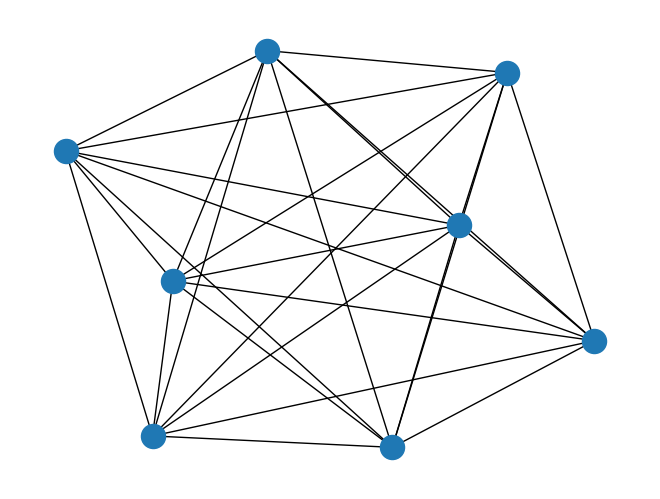

In [60]:
g = tg.utils.to_networkx(data1, to_undirected=True)
nx.draw(g)

In [6]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

Now I want to add graphs with our need for Ng sets for testing

In [7]:
complete_graph_list = []
for i in range(8):
    for j in range(8):
        if i != j:
            complete_graph_list.append([i,j])
edge_index = torch.tensor(complete_graph_list, dtype=torch.long)

In [117]:
edges_to_check = [[2,6], [3,6], [5,6], [4,6]]
vector_y_list = []
for i in range(8):
    for j in range(8):
        if i != j:
            if [i,j] in edges_to_check:
                vector_y_list.append([1])
            else:
                vector_y_list.append([0])
y = torch.tensor(vector_y_list, dtype=torch.long)
x = torch.tensor([[0, 3, 2], [1, 1, 6], [2, 3, 6], [3, 5, 6], [4, 6, 5], [5, 4, 4], [6, 3, 4], [7, 1, 3]], dtype=torch.float)

print(edge_index.t().contiguous())

data1 = Data(x=x, y=y.t().contiguous(), edge_index=edge_index.t().contiguous(), pos=x)

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
         6, 7, 7, 7, 7, 7, 7, 7],
        [1, 2, 3, 4, 5, 6, 7, 0, 2, 3, 4, 5, 6, 7, 0, 1, 3, 4, 5, 6, 7, 0, 1, 2,
         4, 5, 6, 7, 0, 1, 2, 3, 5, 6, 7, 0, 1, 2, 3, 4, 6, 7, 0, 1, 2, 3, 4, 5,
         7, 0, 1, 2, 3, 4, 5, 6]])


In [76]:
edges_to_check = [[3,1], [2,1]]
vector_y_list = []
for i in range(8):
    for j in range(8):
        if i != j:
            if [i,j] in edges_to_check:
                vector_y_list.append([1])
            else:
                vector_y_list.append([0])
y = torch.tensor(vector_y_list, dtype=torch.long)
x = torch.tensor([[0, 4,4], [1, 4,3], [2, 2,5], [3, 2,2], [4, 4,1], [5, 6,6], [6, 7,3], [7, 3,7]], dtype=torch.float)

data2 = Data(x=x, y=y.t().contiguous(), edge_index=edge_index.t().contiguous(), pos=x)

In [77]:
edges_to_check = [[3,7], [5,7]]
vector_y_list = []
for i in range(8):
    for j in range(8):
        if i != j:
            if [i,j] in edges_to_check:
                vector_y_list.append([1])
            else:
                vector_y_list.append([0])
y = torch.tensor(vector_y_list, dtype=torch.long)
x = torch.tensor([[0, 6,2], [1, 1,3], [2, 3,7], [3, 6,6], [4, 1,7], [5, 7,5], [6, 4,3], [7, 7,5]], dtype=torch.float)

data3 = Data(x=x, y=y.t().contiguous(), edge_index=edge_index.t().contiguous(), pos=x)

In [78]:
edges_to_check = [[1,7], [5,7], [2,3], [6,3]]
vector_y_list = []
for i in range(8):
    for j in range(8):
        if i != j:
            if [i,j] in edges_to_check:
                vector_y_list.append([1])
            else:
                vector_y_list.append([0])
y = torch.tensor(vector_y_list, dtype=torch.long)
x = torch.tensor([[0, 4,3], [1, 1,1], [2, 6,6], [3, 7,4], [4, 2,5], [5, 3,1], [6, 7,3], [7, 2,2]], dtype=torch.float)

data4 = Data(x=x, y=y.t().contiguous(), edge_index=edge_index.t().contiguous(), pos=x)

In [148]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(3, 8)
        self.conv2 = GCNConv(8, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.sigmoid(self.conv2(x, edge_index))
        # x = F.dropout(x, training=self.training)
        # x = self.conv2(x, edge_index)

        # return F.log_softmax(x, dim=1)
        return x

In [137]:
data_list = [data1, data2, data3, data4]
dataloader = DataLoader(data_list, batch_size=4)

In [122]:
print(dataloader)
for data in dataloader:
    print(data)

DataBatch(x=[32, 3], edge_index=[2, 224], y=[4, 56], pos=[32, 3], batch=[32], ptr=[5])


In [150]:
for data in dataloader:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN().to(device)
    subdata = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(subdata)
        print(out)
        print(len(out[0]))
        print(len(out.view(-1)))
        loss = F.nll_loss(out, subdata.y)
        loss.backward()
        optimizer.step()

tensor([[0.9062],
        [0.9062],
        [0.9062],
        [0.9062],
        [0.9062],
        [0.9062],
        [0.9062],
        [0.9062],
        [0.9427],
        [0.9427],
        [0.9427],
        [0.9427],
        [0.9427],
        [0.9427],
        [0.9427],
        [0.9427],
        [0.9425],
        [0.9425],
        [0.9425],
        [0.9425],
        [0.9425],
        [0.9425],
        [0.9425],
        [0.9425],
        [0.9513],
        [0.9513],
        [0.9513],
        [0.9513],
        [0.9513],
        [0.9513],
        [0.9513],
        [0.9513]], grad_fn=<SigmoidBackward0>)
1
32


ValueError: Expected input batch_size (32) to match target batch_size (4).

In [31]:
model = GCN(data1.num_node_features,3)
model(loader)

AttributeError: 'DataLoader' object has no attribute 'x'